In [2]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import json
from matplotlib import colors
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Generic methods to convert json format to DataFrame

In [87]:
def compute_metrics(data : dict):
    oc_list = list()
    available_list = list()
    prev_available_list = list()
    deltabooked_list = list()
    correction_list = list()
    percentile_list = list()
    prev_percentile_list = list()
    config_list = list()
    booked_list = list()
    prev_booked = 0
    prev_available = 0
    prev_percentile = 0
    for index in range(len(data["epoch"])):
        available = data["model"]["free_cpu"][index]
        config = data['node']["cpu_config"][index]
        ratio = (data['node']["booked_cpu"][index] + data["model"]["free_cpu"][index])/data['node']["cpu_config"][index]
        percentile = data['node']['cpu_percentile'][index]['99'] 
        booked_list.append(data['node']["booked_cpu"][index])
        delta_booked = data['node']["booked_cpu"][index] - prev_booked
        oc_list.append(ratio)
        available_list.append(available)
        prev_available_list.append(prev_available)
        deltabooked_list.append(delta_booked)
        if delta_booked>=0:
            correction_list.append(delta_booked)
        else:
            correction_list.append(percentile - prev_percentile)
        percentile_list.append(percentile)
        prev_percentile_list.append(prev_percentile)
        config_list.append(config)
        prev_available = available
        prev_percentile = percentile
        prev_booked = data['node']["booked_cpu"][index]
    return oc_list, available_list, prev_available_list, deltabooked_list, correction_list, percentile_list, prev_percentile_list, config_list, booked_list

def add_line(dict_to_use : dict, curr_strategy, curr_iteration, oc_ratio, available, prev_available, delta_booked, correction, percentile, prev_percentile, config, booked_cpu):
    dict_to_use["strategy"].append(curr_strategy)
    dict_to_use["iteration"].append(curr_iteration)
    dict_to_use["ratio"].append(oc_ratio)
    dict_to_use["available"].append(available)
    dict_to_use["prev_available"].append(prev_available)
    dict_to_use["delta_booked"].append(delta_booked)
    dict_to_use["correction"].append(correction)
    dict_to_use["percentile"].append(percentile)
    dict_to_use["prev_percentile"].append(prev_percentile)
    dict_to_use["config"].append(config)
    dict_to_use["booked"].append(booked_cpu)

def convert_res_to_cumul(input_df : pd.DataFrame):
    pd.options.mode.chained_assignment = None 
    
    cumul_res_dic= dict()
    cumul_res_dic['strategy'] = list()
    cumul_res_dic['iteration'] = list()
    cumul_res_dic['violation'] = list()
    cumul_res_dic['violation_cumulated'] = list()
    cumul_res_dic['violation_cumulated%'] = list()
    cumul_res_dic['misprediction'] = list()
    cumul_res_dic['misprediction_cumulated'] = list()
    cumul_res_dic['misprediction_cumulated%'] = list()
    cumul_res_dic['decreases'] = list()
    cumul_res_dic['decreases_cumulated'] = list()
    cumul_res_dic['decreases_cumulated%'] = list()

    for strategy in list(input_df['strategy'].unique()):

        x = input_df.loc[input_df['strategy'] ==  strategy]
        x['violation'] = x['current_available_misprediction'].apply(lambda x : np.abs(x) if x < 0 else 0)
        x['misprediction'] = x['current_available_misprediction'].apply(lambda x : np.abs(x))
        x['decreases'] = x['delta_available'].apply(lambda x : np.abs(x) if x < 0 else 0)

        iteration_list = list()
        violation_list = list()
        violation_cumulated_list = list()
        violation_cumulated_val = 0
        misprediction_list = list()
        misprediction_cumulated_list = list()
        misprediction_cumulated_val = 0
        decreases_list = list()
        decreases_cumulated_list = list()
        decreases_cumulated_val = 0
        for index, row in x.iterrows():
            iteration_list.append(row['iteration'])
            violation_list.append(row['violation'])
            violation_cumulated_val += row['violation']
            violation_cumulated_list.append(violation_cumulated_val)
            misprediction_list.append(row['misprediction'])
            misprediction_cumulated_val += row['misprediction']
            misprediction_cumulated_list.append(misprediction_cumulated_val)
            decreases_list.append(row['decreases'])
            decreases_cumulated_val += row['decreases']
            decreases_cumulated_list.append(decreases_cumulated_val)

        cumul_res_dic['iteration'].extend(iteration_list)
        cumul_res_dic['strategy'].extend([strategy for val in iteration_list])
        cumul_res_dic['violation'].extend(violation_list)
        cumul_res_dic['violation_cumulated'].extend(violation_cumulated_list)
        cumul_res_dic['violation_cumulated%'].extend([(x - np.min(violation_cumulated_list))/(np.max(violation_cumulated_list)-np.min(violation_cumulated_list)) for x in violation_cumulated_list])
        cumul_res_dic['misprediction'].extend(misprediction_list)
        cumul_res_dic['misprediction_cumulated'].extend(misprediction_cumulated_list)
        cumul_res_dic['misprediction_cumulated%'].extend([(x - np.min(misprediction_cumulated_list))/(np.max(misprediction_cumulated_list)-np.min(misprediction_cumulated_list)) for x in misprediction_cumulated_list])
        cumul_res_dic['decreases'].extend(decreases_list)
        cumul_res_dic['decreases_cumulated'].extend(decreases_cumulated_list)
        cumul_res_dic['decreases_cumulated%'].extend([(x - np.min(decreases_cumulated_list))/(np.max(decreases_cumulated_list)-np.min(decreases_cumulated_list)) for x in decreases_cumulated_list])
    
    return pd.DataFrame(cumul_res_dic)

def compute_eval_metrics(dataframe : pd.DataFrame, config : int):
    from collections import defaultdict
    res_dic = defaultdict(lambda : list())
    
    for strategy in list(dataframe['strategy'].unique()):

        res_dic['strategy'].append(strategy)

        x = dataframe.loc[dataframe['strategy'] ==  strategy]
        res_dic['misprediction'].append(x['misprediction_cumulated'].max())
        res_dic['violation'].append(x['violation_cumulated'].max())
        res_dic['decreases'].append(x['decreases_cumulated'].max())

    res_df = pd.DataFrame(res_dic)
    res_df['misprediction'] = res_df['misprediction'].apply(lambda x : round(x/config,1))
    res_df['violation'] = res_df['violation'].apply(lambda x : round(x/config,1))
    res_df['decreases'] = res_df['decreases'].apply(lambda x : round(x/config,1))
    
    return res_df

def load_folder(folder : str):
    input_strat = dict()
    strategies = ['borg', 'doa', 'scroogevm', 'nsigma', 'rclike']
    for strategy in strategies:
        input_strat[strategy] = folder + "/dump-" + strategy + ".json"
    
    compare_strat_dict = dict()
    compare_strat_dict["iteration"] = list()
    compare_strat_dict["strategy"] = list()
    compare_strat_dict["ratio"] = list()
    compare_strat_dict["available"] = list()
    compare_strat_dict["prev_available"] = list()
    compare_strat_dict["percentile"] = list()
    compare_strat_dict["booked"] = list()
    compare_strat_dict["delta_booked"] = list()
    compare_strat_dict["correction"] = list()
    compare_strat_dict["prev_percentile"] = list()
    compare_strat_dict["config"] = list()
    
    for strat, file in input_strat.items():
        print("Loading", strat, file)
        with open(file, 'r') as f:
            targeted_data = json.load(f)
        oc_list, available_list, prev_available_list, deltabooked_list, correction_list, percentile_list, prev_percentile_list, config_list, booked_list = compute_metrics(targeted_data)
        for iteration_curr in range(len(oc_list)):
            add_line(compare_strat_dict, strat, iteration_curr, oc_list[iteration_curr], available_list[iteration_curr], prev_available_list[iteration_curr], deltabooked_list[iteration_curr], correction_list[iteration_curr], percentile_list[iteration_curr], prev_percentile_list[iteration_curr], config_list[iteration_curr], booked_list[iteration_curr])
    print("Done")
    
    return compare_strat_dict

# Load the "decreasing workload" trace

In [88]:
# Folder to adapt
folder = "/usr/local/src/scroogevm/dump-decrease"

decreasing_df = pd.DataFrame(load_folder(folder))

Loading borg /usr/local/src/scroogevm/dump-decrease/dump-borg.json
Loading doa /usr/local/src/scroogevm/dump-decrease/dump-doa.json
Loading scroogevm /usr/local/src/scroogevm/dump-decrease/dump-scroogevm.json
Loading nsigma /usr/local/src/scroogevm/dump-decrease/dump-nsigma.json
Loading rclike /usr/local/src/scroogevm/dump-decrease/dump-rclike.json
Done


In [89]:
decreasing_df = decreasing_df.loc[decreasing_df["iteration"] < 30]
decreasing_df = decreasing_df.loc[decreasing_df["iteration"] > 0]

decreasing_df["prev_available_corrected"] = decreasing_df["prev_available"] - decreasing_df["correction"]
decreasing_df["available_groundthruth"] = decreasing_df["config"] - decreasing_df["percentile"]
decreasing_df["delta_available"] = decreasing_df["available"] - decreasing_df["prev_available_corrected"]

decreasing_df["current_available_misprediction"] = decreasing_df["available_groundthruth"] - decreasing_df["prev_available_corrected"]
decreasing_df["current_available_misprediction%"] = decreasing_df["current_available_misprediction"] / decreasing_df["config"]
decreasing_df["oversubscription"] = (decreasing_df["booked"] + decreasing_df["available"])/decreasing_df["config"]

strategies = decreasing_df['strategy'].unique()

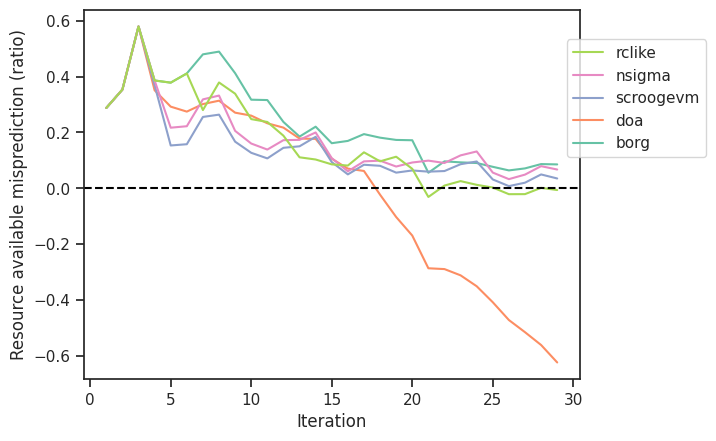

In [90]:
#hue_order = ['percentile', 'greedy', 'doa']
colors = sns.color_palette("husl", 10)

sns.lineplot(data=decreasing_df, x="iteration", y="current_available_misprediction%", hue="strategy") #, palette=[colors[0], colors[5], 'darkorange'], hue_order=hue_order)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Iteration')
x = plt.legend(ncol=1, loc="lower right", frameon=True, reverse=True, bbox_to_anchor=(1.27, 0.58))
x = plt.ylabel('Resource available misprediction (ratio)')

/tmp/ipykernel_324858/2652984273.py:99: RuntimeWarning: invalid value encountered in scalar divide
  cumul_res_dic['violation_cumulated%'].extend([(x - np.min(violation_cumulated_list))/(np.max(violation_cumulated_list)-np.min(violation_cumulated_list)) for x in violation_cumulated_list])
/tmp/ipykernel_324858/2652984273.py:99: RuntimeWarning: invalid value encountered in scalar divide
  cumul_res_dic['violation_cumulated%'].extend([(x - np.min(violation_cumulated_list))/(np.max(violation_cumulated_list)-np.min(violation_cumulated_list)) for x in violation_cumulated_list])
/tmp/ipykernel_324858/2652984273.py:99: RuntimeWarning: invalid value encountered in scalar divide
  cumul_res_dic['violation_cumulated%'].extend([(x - np.min(violation_cumulated_list))/(np.max(violation_cumulated_list)-np.min(violation_cumulated_list)) for x in violation_cumulated_list])


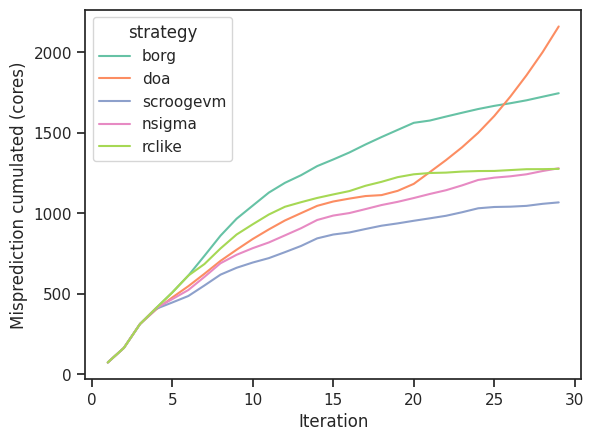

In [95]:
decreasing_cumul_res_df = convert_res_to_cumul(input_df=decreasing_df)
# decreases_cumulated violation_cumulated misprediction_cumulated

#sns.set_color_codes(palette='Set2')
sns.set_theme(style="ticks")
sns.set_palette(palette='Set2')
x = sns.lineplot(data=decreasing_cumul_res_df, x="iteration", y="misprediction_cumulated", hue="strategy")
x.set_xlabel('Iteration')
x.set_ylabel('Misprediction cumulated (cores)')
plt.gcf().savefig('figures/misprediction-decreasing.pdf', bbox_inches='tight')

In [93]:
res_df = compute_eval_metrics(decreasing_cumul_res_df, config=256)

res_df_x = res_df.loc[res_df['strategy'] != 'doa']
res_df_x.head(n=10)

,strategy,misprediction,violation,decreases
0,borg,6.8,0.0,0.2
2,scroogevm,4.2,0.0,0.3
3,nsigma,5.0,0.0,0.3
4,rclike,5.0,0.1,0.2


# Load the "increasing workload" trace

In [94]:
folder = "/usr/local/src/scroogevm/dump-increase"

increasing_df = pd.DataFrame(load_folder(folder))

Loading borg /usr/local/src/scroogevm/dump-increase/dump-borg.json
Loading doa /usr/local/src/scroogevm/dump-increase/dump-doa.json
Loading scroogevm /usr/local/src/scroogevm/dump-increase/dump-scroogevm.json
Loading nsigma /usr/local/src/scroogevm/dump-increase/dump-nsigma.json
Loading rclike /usr/local/src/scroogevm/dump-increase/dump-rclike.json
Done


In [96]:
increasing_df = increasing_df.loc[increasing_df["iteration"] < 30]
increasing_df = increasing_df.loc[increasing_df["iteration"] > 0]

increasing_df["prev_available_corrected"] = increasing_df["prev_available"] - increasing_df["correction"]
increasing_df["delta_available"] = increasing_df["available"] - increasing_df["prev_available_corrected"]
increasing_df["current_available"] = increasing_df["config"] - increasing_df["percentile"]
increasing_df["oversubscription"] = (increasing_df["booked"] + increasing_df["available"])/increasing_df["config"]

increasing_df["current_available_misprediction"] = increasing_df["current_available"] - increasing_df["prev_available_corrected"]
increasing_df["current_available_misprediction%"] = increasing_df["current_available_misprediction"] / increasing_df["config"]

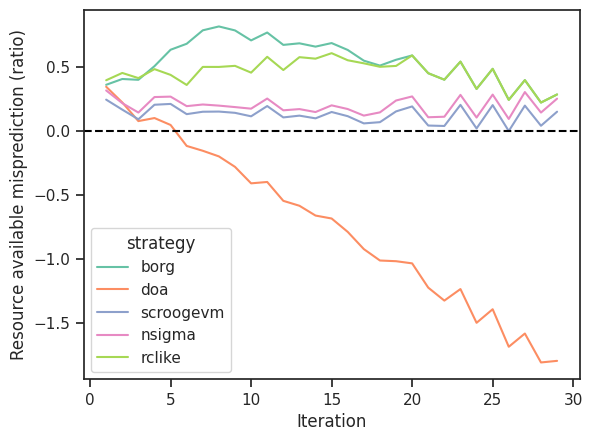

In [97]:
#hue_order = ['percentile', 'greedy', 'doa']
colors = sns.color_palette("husl", 10)

sns.lineplot(data=increasing_df, x="iteration", y="current_available_misprediction%", hue="strategy") # , palette=[colors[0], colors[5], 'darkorange'], hue_order=hue_order)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Iteration')
x = plt.ylabel('Resource available misprediction (ratio)')

/tmp/ipykernel_324858/2652984273.py:99: RuntimeWarning: invalid value encountered in scalar divide
  cumul_res_dic['violation_cumulated%'].extend([(x - np.min(violation_cumulated_list))/(np.max(violation_cumulated_list)-np.min(violation_cumulated_list)) for x in violation_cumulated_list])
/tmp/ipykernel_324858/2652984273.py:105: RuntimeWarning: invalid value encountered in scalar divide
  cumul_res_dic['decreases_cumulated%'].extend([(x - np.min(decreases_cumulated_list))/(np.max(decreases_cumulated_list)-np.min(decreases_cumulated_list)) for x in decreases_cumulated_list])
/tmp/ipykernel_324858/2652984273.py:99: RuntimeWarning: invalid value encountered in scalar divide
  cumul_res_dic['violation_cumulated%'].extend([(x - np.min(violation_cumulated_list))/(np.max(violation_cumulated_list)-np.min(violation_cumulated_list)) for x in violation_cumulated_list])
/tmp/ipykernel_324858/2652984273.py:99: RuntimeWarning: invalid value encountered in scalar divide
  cumul_res_dic['violation_cum

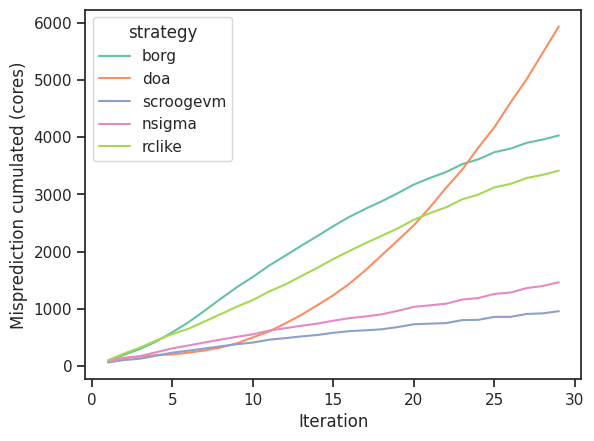

In [98]:
increasing_cumul_res_df = convert_res_to_cumul(input_df=increasing_df)

#sns.set_color_codes(palette='Set2')
sns.set_theme(style="ticks")
sns.set_palette(palette='Set2')
x = sns.lineplot(data=increasing_cumul_res_df, x="iteration", y="misprediction_cumulated", hue="strategy")
x.set_xlabel('Iteration')
x.set_ylabel('Misprediction cumulated (cores)')
plt.gcf().savefig('figures/misprediction-increasing.pdf', bbox_inches='tight')

In [100]:
res_df = compute_eval_metrics(increasing_cumul_res_df, config=256)
res_df.head(n=10)

,strategy,misprediction,violation,decreases
0,borg,15.7,0.0,0.0
1,doa,23.2,22.4,0.3
2,scroogevm,3.7,0.0,0.0
3,nsigma,5.7,0.0,0.0
4,rclike,13.3,0.0,0.0
